<a href="https://colab.research.google.com/github/CameronBannick/Sales_Predictions/blob/main/05_Sales_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library and Data Imports

In [1]:
#standard imports 
import pandas as pd
import numpy as np
#data visualization impports
import matplotlib.pyplot as plt
import seaborn as sns
#sklearn imports
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import set_config
set_config(display='diagram')

In [2]:
#defining filepath
filename = 'DATA/sales_predictions.csv'
#import data
df = pd.read_csv(filename)
#view data
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
#check for duplicate data
df.duplicated().sum()

0

In [4]:
#inspecting info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
#check for missing data
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [6]:
#dropping columns deemed irrelevant
df = df.drop(columns=['Item_Weight', 'Outlet_Size', 'Outlet_Identifier', 'Outlet_Location_Type', 'Outlet_Type' ])
df.head()

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,FDA15,Low Fat,0.016047,Dairy,249.8092,1999,3735.1380
1,DRC01,Regular,0.019278,Soft Drinks,48.2692,2009,443.4228
2,FDN15,Low Fat,0.016760,Meat,141.6180,1999,2097.2700
3,FDX07,Regular,0.000000,Fruits and Vegetables,182.0950,1998,732.3800
4,NCD19,Low Fat,0.000000,Household,53.8614,1987,994.7052


In [7]:
#confirming there are no more missing values
df.isna().sum()

Item_Identifier              0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Item_Outlet_Sales            0
dtype: int64

In [8]:
#inspecting values for feature
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [9]:
#reverting redundant values for consistency
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [10]:
#inspecting values for features 
df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

# Data Visualizations

## Creating Variables for Feature Statistics

### Item MRP

In [12]:
#defining item_mrp minimum
item_mrp_min = df['Item_MRP'].min().round(2)
item_mrp_min

31.29

In [13]:
#defining item_mrp mean
item_mrp_mean = df['Item_MRP'].mean().round(2)
item_mrp_mean

140.99

In [14]:
#defining item_mrp maximum
item_mrp_max = df['Item_MRP'].max().round(2)
item_mrp_max

266.89

### Item Outlet Sales

In [15]:
#defining item_sales minimum
item_sales_min = df['Item_Outlet_Sales'].min().round(2)
item_sales_min

33.29

In [16]:
#defining item_sales mean
item_sales_mean = df['Item_Outlet_Sales'].mean().round(2)
item_sales_mean

2181.29

In [17]:
#defining item sales maximum  
item_sales_max = df['Item_Outlet_Sales'].max().round(2)
item_sales_max

13086.96

## Data Visualization 



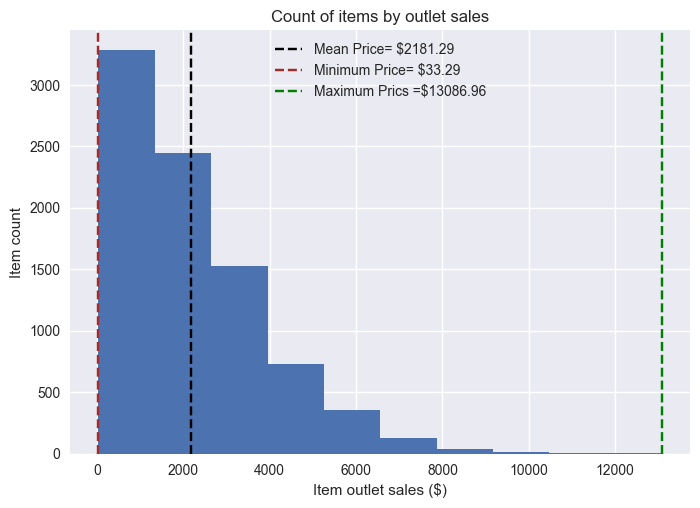

In [18]:
#creating histogram for Item_Outlet_Sales feature
plt.style.use('seaborn')
fig, ax = plt.subplots()
ax.hist(df['Item_Outlet_Sales'])
ax.set_title('Count of items by outlet sales')
ax.set_xlabel('Item outlet sales ($)')
ax.set_ylabel('Item count')
ax.axvline(item_sales_mean, color='Black', linestyle='--', label=f"Mean Price= ${item_sales_mean}" )
ax.axvline(item_sales_min, color='Brown', linestyle='--', label=f"Minimum Price= ${item_sales_min}")
ax.axvline(item_sales_max, color='Green', linestyle='--', label=f"Maximum Prics =${item_sales_max}")
ax.legend()
plt.show()

The Histogram above shows how many items are bringing in  a certain amount of outlet sales. Most of the items sell between 33 (see labeled minimum) and about 2,500 dollars. There is still around 1,500 instances each between 2,500 and 3,800 dollars, but a significant drop after past 4,000 dollars. However, even though the maximum is 13086.96 dollars, a good amount of those are most likely outliers.

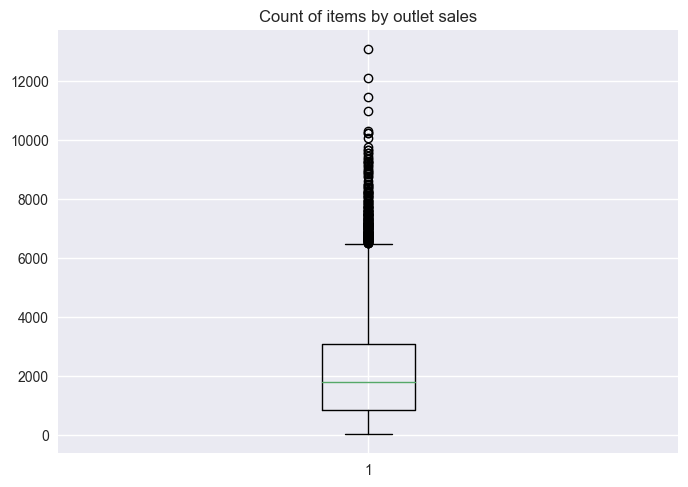

In [19]:
#creating boxplot for Item_Outlet_Sales
fig, ax = plt.subplots()
ax.boxplot(df['Item_Outlet_Sales'])
ax.set_title('Count of items by outlet sales')
plt.show()

The boxplot tells us that all the black circles past the box itself are outliers. Thats roughly a little over 6,000 dollars. The two black lines around the box are our minimum and maximum shown in the previous visual, but the box itself is where most of the money is being made. Products bringing in 1,000 to 3,000 dollars in Item Outlet Sales are selling the most.

In [20]:
#using groupby to group items by mean outlet sales
item_mean = df.groupby('Item_Type')['Item_Outlet_Sales'].mean().round(2)
item_mean.head()

Item_Type
Baking Goods    1952.97
Breads          2204.13
Breakfast       2111.81
Canned          2225.19
Dairy           2232.54
Name: Item_Outlet_Sales, dtype: float64

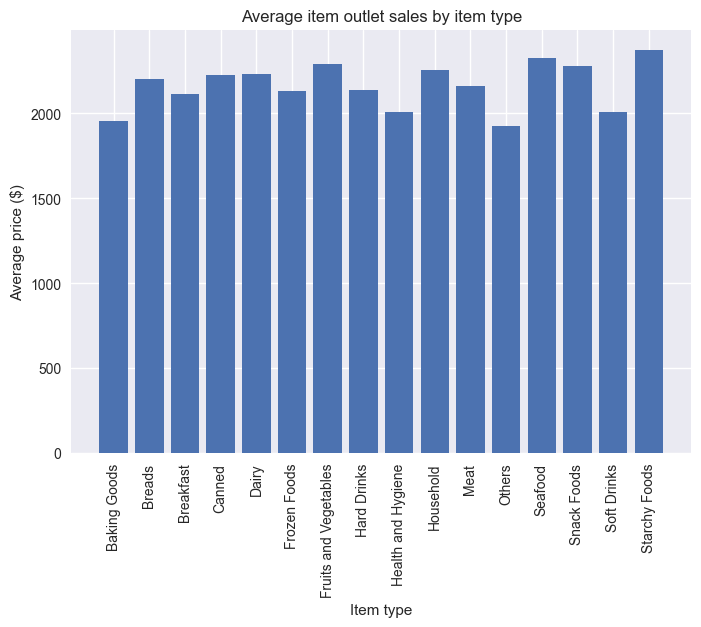

In [21]:
#creating barplot for average item outlet sales by item
fig, ax = plt.subplots()
ax.bar(item_mean.index, item_mean.values)
ax.set_title('Average item outlet sales by item type')
ax.set_xlabel('Item type')
ax.set_ylabel('Average price ($)')
plt.xticks(rotation=90)
plt.show()

The last visual shows the average Item Outlet Sales by Item Type. It seems all the Item Types on average do around the same sales, around 2,000 dollars. Some dip 500 dollars more or 500 dollars less, but there seems to be no significant outliers on average.

# Machine Learning Predictive Model

## Preprocessing Data

In [24]:
#train test split data
X = df.drop(columns='Item_Outlet_Sales')
y= df['Item_Outlet_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [25]:
#creating instances of StandardScaler and OneHotEncoder
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
#column selectors by data type
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
#cre
cat_tuple = (ohe, cat_selector)
num_tuple = (scaler, num_selector)

In [27]:
#creating preprocessor 
preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='drop')
preprocessor

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002251C990550>),
                                ('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002251C9907C0>)])

## Model 1: Linnear Regression

In [28]:
#create instance of model
linreg = LinearRegression()
#create pipeline for model
linreg_pipe = make_pipeline(preprocessor, linreg)
#fit training data
linreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002251C990550>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002251C9907C0>)])),
                ('linearregression', LinearRegression())])

In [29]:
#predictions for model
train_predict = linreg_pipe.predict(X_train)
test_predict = linreg_pipe.predict(X_test)

In [30]:
#r2 score metric
train_r2 = r2_score(y_train, train_predict)
test_r2 = r2_score(y_test, test_predict)

print(f'Train R2: {round(train_r2,2)}')
print(f'Test R2: {round(test_r2,2)}')

Train R2: 0.52
Test R2: -2.463093780090175e+21


In [31]:
train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_test, test_predict)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(f'Train RMSE: {round(train_rmse,2)}')
print(f'Test RMSE: {round(test_rmse,2)}')


Train RMSE: 1189.43
Test RMSE: 82435549352246.28


## Bagged Tree

In [32]:
bagreg = BaggingRegressor(random_state=42)

bagreg_pipe = make_pipeline(preprocessor, bagreg)

bagreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002251C990550>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002251C9907C0>)])),
                ('baggingregressor', BaggingRegressor(random_state=42))])

In [33]:
train_pred =  bagreg_pipe.predict(X_train)
test_pred = bagreg_pipe.predict(X_test)

In [34]:
br2_train = bagreg_pipe.score(X_train, y_train)
br2_test = bagreg_pipe.score(X_test, y_test)

print(f'Train R2: {round(br2_train,2)}')
print(f'Test R2: {round(br2_test,2)}')

Train R2: 0.89
Test R2: 0.31


In [35]:
train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_test, test_predict)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(f'Train RMSE: {round(train_rmse,2)}')
print(f'Test RMSE: {round(test_rmse,2)}')


Train RMSE: 1189.43
Test RMSE: 82435549352246.28


I would definitely advise the Bagged Tree model over the Linear Regression model due to the best R2 and RMSE score, however, my reccomendation would be to come up with some more model ideas to see if there is a better option